In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pylab as plt
plt.style.use('ggplot')
import astropy.units as au
import os

import gpflow as gp
from heterogp.latent import Latent
from gpflow import settings
import logging
logging.basicConfig(format='%(asctime)s %(message)s')
import tensorflow as tf



# Some helper functions

In [2]:
from gpflow.actions import Loop, Action
from gpflow.training import AdamOptimizer

class PrintAction(Action):
    def __init__(self, model, text):
        self.model = model
        self.text = text
        
    def run(self, ctx):
        likelihood = ctx.session.run(self.model.likelihood_tensor)
        logging.warning('{}: iteration {} likelihood {:.4f}'.format(self.text, ctx.iteration, likelihood))
#         logging.warning(self.model)
        
def run_with_adam(model, lr,iterations, callback=None):
    
    adam = AdamOptimizer(lr).make_optimize_action(model)
    
    actions = [adam]#natgrad,
    actions = actions if callback is None else actions + [callback]

    Loop(actions, stop=iterations)()
    model.anchor(model.enquire_session())

# Define some data with input-dependent noise

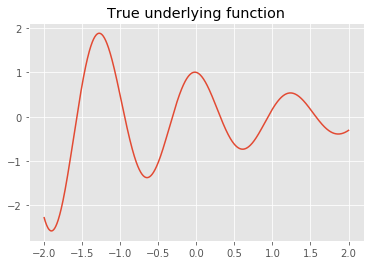

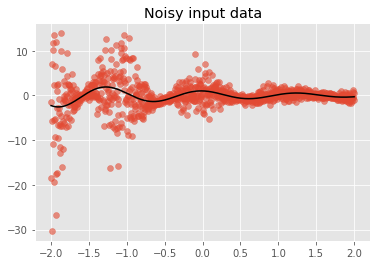

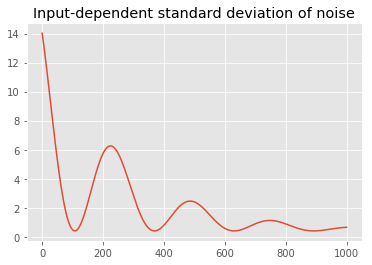

In [3]:
def func(X):
    return np.cos(5*X)*np.exp(-X/2)

N = 1000
X = np.linspace(-2,2,N)[:,None]
noise = 4*np.abs(0.25*(np.cos(6*X)+1)*np.exp(-X) + 0.1)
Y = func(X) + noise*np.random.normal(size=X.shape)

plt.plot(X[:,0],func(X)[:,0],alpha=1.)
plt.title("True underlying function")
plt.show()

plt.scatter(X[:,0],Y[:,0],alpha=0.6)
plt.plot(X[:,0],func(X)[:,0],alpha=1.,c='black')
plt.title("Noisy input data")
plt.show()
plt.title("Input-dependent standard deviation of noise")
plt.plot(noise)
plt.show()

# Vanilla solution

In [ ]:
from gpflow.models import SVGP

settings.numerics.jitter_level=1e-6
iterations = 1000
Z = np.linspace(-2,2,100)[:,None]

with tf.Session(graph=tf.Graph()) as sess:
    with gp.defer_build():
        
        # Define the likelihood
        likelihood = gp.likelihoods.Gaussian()
        # Define the underlying GP mean and kernel
        mean = gp.mean_functions.Zero()
        kernel = gp.kernels.RBF(1)
        # Create the HGP (note the slightly different order from SVGP)
        model = SVGP(X, Y, kernel, likelihood, 
                     mean_function=mean, 
                     minibatch_size=100,
                     num_latent = 1, 
                     num_data=None,
                     whiten=False,
                    Z=Z)
        model.compile()
    
    run_with_adam(model,1e-3,iterations, PrintAction(model,"Adam"))
    # Predictions uses stochastic sampling and produces 
    # [num_samples,N,D] shape output
    ystar,varstar = model.predict_y(X)
    

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(X[:,0],ystar,alpha=1,c='r',label='vanilla-inferred')
plt.fill_between(X[:,0],np.squeeze(ystar+np.sqrt(varstar)),
                 np.squeeze(ystar-np.sqrt(varstar)),
                 alpha=0.5)
plt.plot(X[:,0],Y[:,0],c='b',alpha=0.5,label='data')
plt.plot(X[:,0],func(X) + 5,ls='--',label='True offset by 5')
plt.legend()
# plt.title("Inferred solution on data")
plt.savefig("vanilla.png")
plt.show()

# Define the HGP model and train

We will:
  - Define the latent GP that models the noise
  - Define heteroscedastic likelihood which uses the above latent
  - Define the HGP which has another independent latent modelling the
  underlying function
  - Finally, train with Adam and plot the results

In [4]:
from heterogp.likelihoods import HeteroscedasticGaussian
from heterogp.hgp import HGP

settings.numerics.jitter_level=1e-6
iterations = 1000
Z = np.linspace(-2,2,100)[:,None]

with tf.Session(graph=tf.Graph()) as sess:
    with gp.defer_build():
        
        
        # Define the (log) noise latent
        mean = gp.mean_functions.Constant(np.log(0.5))
        kern = gp.kernels.RBF(1)
        log_noise_latent = Latent(Z, mean, kern, num_latent=1, whiten=False, name=None)
        # Define the likelihood
        likelihood = HeteroscedasticGaussian(log_noise_latent)
        log_noise_latent
        # Define the underlying GP mean and kernel
        mean = gp.mean_functions.Zero()
        kernel = gp.kernels.RBF(1)
        # Create the HGP (note the slightly different order from SVGP)
        model = HGP(X, Y, Z, kernel, likelihood, 
                     mean_function=mean, 
                     minibatch_size=500,
                     num_latent = 1, 
                     num_samples=1,
                     num_data=None,
                     whiten=False)
        model.compile()
    from timeit import default_timer
    t0 = default_timer()
    run_with_adam(model,1e-3,iterations,PrintAction(model,"Adam"))
    print(default_timer() - t0)
    # Predictions uses stochastic sampling and produces 
    # [num_samples,N,D] shape output
    ystar,varstar = model.predict_y(X, 100)
    # For plotting the noise
    hetero_noise = model.likelihood.compute_hetero_noise(X,100)

53.31105418398511


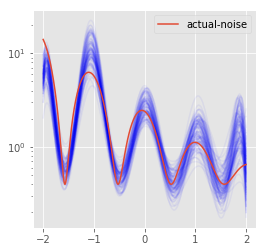

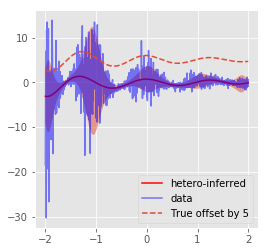

In [5]:
plt.figure(figsize=(4,4))
plt.plot(X[:,0],hetero_noise[:,:,0].T,alpha=0.05,c='b')
# plt.title("Samples for the noise latent")
plt.plot(X[:,0],noise,label='actual-noise')
plt.yscale('log')
plt.legend()
plt.savefig("inferred_noise.png")
plt.show()

plt.figure(figsize=(4,4))
plt.plot(X[:,0],ystar.mean(0),alpha=1,c='r',label='hetero-inferred')
plt.fill_between(X[:,0],np.squeeze(ystar.mean(0)+np.sqrt(varstar.mean(0))),
                 np.squeeze(ystar.mean(0)-np.sqrt(varstar.mean(0))),
                 alpha=0.5)
plt.plot(X[:,0],Y[:,0],c='b',alpha=0.5,label='data')
plt.plot(X[:,0],func(X) + 5,ls='--',label='True offset by 5')
plt.legend()
# plt.title("Inferred solution on data")
plt.savefig("hetero_inferred.png")
plt.show()

In [6]:
def test_print():
    Z = tf.zeros([3,4])
    Z = tf.print(Z,[Z.shape[0],'any thing i want'],message='Debug message:',summarize=100)
    return Z


# sess = tf.Session()
# sess.run(test_print())
# sess.close()